In [ ]:
from mpmath import mp
import numpy as np
import matplotlib.pyplot as plt
import time


# Precisión de mpmath


def set_precision(dps=50):
    mp.dps = dps




def _main_sum_zeta(s, N):
    N = int(N)
    total = mp.mpc(0)
    for n in range(1, N):
        total += n ** (-s)
    return total

def _tail_integral(s, N):
    N = mp.mpf(N)
    return N ** (1 - s) / (s - 1)

def _tail_half_term(s, N):
    N = mp.mpf(N)
    return mp.mpf('0.5') * N ** (-s)

def _tail_corrections(s, N, m):
    N = mp.mpf(N)
    corrections = mp.mpc(0)
    for k in range(1, m + 1):
        B_2k = mp.bernoulli(2 * k)   # B_{2k}
        fact = mp.factorial(2 * k)   # (2k)!
        rising = mp.rf(s, 2 * k - 1) # (s)_{2k-1}
        term = (B_2k / fact) * rising * N ** (-s - 2 * k + 1)
        corrections += term
    return corrections

def _tail_em(s, N, m):
    return _tail_integral(s, N) + _tail_half_term(s, N) + _tail_corrections(s, N, m)



def zeta_em_s(s, N, m=2):
    """Aproximación de ζ(s) mediante Euler–Maclaurin."""
    s = mp.mpc(s)
    main_sum = _main_sum_zeta(s, N)
    tail = _tail_em(s, N, m)
    return main_sum + tail

def zeta_em(t, N, m=2):
    """Aproximación de ζ(1/2 + i t) mediante Euler–Maclaurin."""
    t = mp.mpf(t)
    s = mp.mpf('0.5') + 1j * t
    return zeta_em_s(s, N, m)


# Test numérico


def test_em_values(N=160, m=3, dps=50):
    set_precision(dps)

    t_values = [
        10,
        20,
        30,
        14.13472514,   # Primer cero
        21.02203964,   # Segundo cero
        25.01085758,   # Tercer cero
        100.0,
        200.0
    ]

    print(f"\n--- Test EM con N={N}, m={m}, dps={dps} ---\n")
    print(f"{'t':>12} | {'zeta_mpmath':>30} | {'zeta_EM':>30} | {'err_abs':>12} | {'err_rel':>12}")
    print("-"*120)

    for t in t_values:
        s = 0.5 + 1j*t

        z_ref = mp.zeta(s)
        z_em_ = zeta_em(t, N, m)

        err_abs = abs(z_ref - z_em_)
        err_rel = err_abs / abs(z_ref) if z_ref != 0 else mp.nan


        t_print       = float(t)
        err_abs_print = float(err_abs)
        err_rel_print = float(err_rel) if not mp.isnan(err_rel) else float('nan')

        print(f"{t_print:12.8f} | {str(z_ref)[:30]:>30} | {str(z_em_)[:30]:>30} | {err_abs_print:12.2e} | {err_rel_print:12.2e}")

    print("\nTest completado.\n")



# Ejecutamos test por defecto:
test_em_values()



--- Test EM con N=160, m=3, dps=50 ---

           t |                    zeta_mpmath |                        zeta_EM |      err_abs |      err_rel
------------------------------------------------------------------------------------------------------------------------
 10.00000000 | (1.544895220296752766921495888 | (1.544895220296752620631228124 |     4.02e-16 |     2.59e-16
 20.00000000 | (0.429913860437843372157739670 | (0.429913860437813923980820029 |     3.58e-14 |     3.12e-14
 30.00000000 | (-0.12064228759004369991402114 | (-0.12064228759047821623808015 |     5.67e-13 |     9.52e-13
 14.13472514 | (0.000000000216315963264359478 | (0.000000000216319230938610658 |     3.58e-15 |     2.60e-06
 21.02203964 | (0.000000000305550653674656412 | (0.000000000305507952960517028 |     5.01e-14 |     3.58e-05
 25.01085758 | (0.000000000065565426515637550 | (0.000000000065437420509121592 |     1.63e-13 |     8.16e-04
100.00000000 | (2.692619885681324090476096470 | (2.692619887962281268380303

In [ ]:
#con tiempos

import time

def test_em_values(N=150, m=3, dps=50):
    set_precision(dps)

    t_values = [
        10,
        20,
        30,
        14.13472514,   # Primer cero
        21.02203964,   # Segundo cero
        25.01085758,   # Tercer cero
        100.0,
        200.0,
        500.0,
        1000.0,
        2000.0,
        3000.0
    ]

    print(f"\n--- Test EM con N={N}, m={m}, dps={dps} ---\n")

    header = (
        f"{'t':>12} | {'zeta_mpmath':>30} | {'zeta_EM':>30} | "
        f"{'err_abs':>12} | {'err_rel':>12} | {'time_s':>10}"
    )
    print(header)
    print("-" * len(header))

    for t in t_values:
        s = 0.5 + 1j * t

        # Valor de referencia
        z_ref = mp.zeta(s)

        # Tiempo del método EM
        t0 = time.perf_counter()
        z_em_ = zeta_em(t, N, m)
        t1 = time.perf_counter()
        elapsed = t1 - t0

        # Errores
        err_abs = abs(z_ref - z_em_)
        err_rel = err_abs / abs(z_ref) if z_ref != 0 else mp.nan

        # Todo a float para formatear sin problemas
        t_print     = float(t)
        z_ref_real  = float(mp.re(z_ref))
        z_em_real   = float(mp.re(z_em_))
        err_abs_f   = float(err_abs)
        err_rel_f   = float(err_rel) if not mp.isnan(err_rel) else float('nan')
        elapsed_f   = float(elapsed)

        print(
            f"{t_print:12.8f} | "
            f"{z_ref_real:30.12f} | "
            f"{z_em_real:30.12f} | "
            f"{err_abs_f:12.2e} | "
            f"{err_rel_f:12.2e} | "
            f"{elapsed_f:10.4f}"
        )

    print("\nTest completado.\n")

test_em_values()


--- Test EM con N=150, m=3, dps=50 ---

           t |                    zeta_mpmath |                        zeta_EM |      err_abs |      err_rel |     time_s
-------------------------------------------------------------------------------------------------------------------------
 10.00000000 |                 1.544895220297 |                 1.544895220297 |     6.52e-16 |     4.21e-16 |     0.0069
 20.00000000 |                 0.429913860438 |                 0.429913860438 |     5.80e-14 |     5.06e-14 |     0.0071
 30.00000000 |                -0.120642287590 |                -0.120642287590 |     9.20e-13 |     1.54e-12 |     0.0068
 14.13472514 |                 0.000000000216 |                 0.000000000216 |     5.81e-15 |     4.22e-06 |     0.0063
 21.02203964 |                 0.000000000306 |                 0.000000000306 |     8.12e-14 |     5.82e-05 |     0.0059
 25.01085758 |                 0.000000000066 |                 0.000000000065 |     2.65e-13 |     1.32e

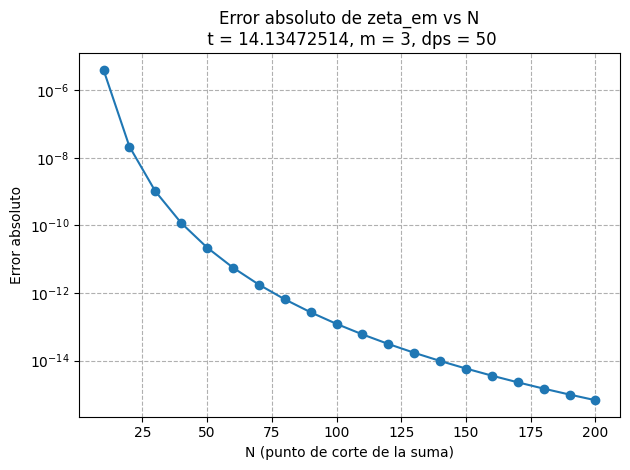

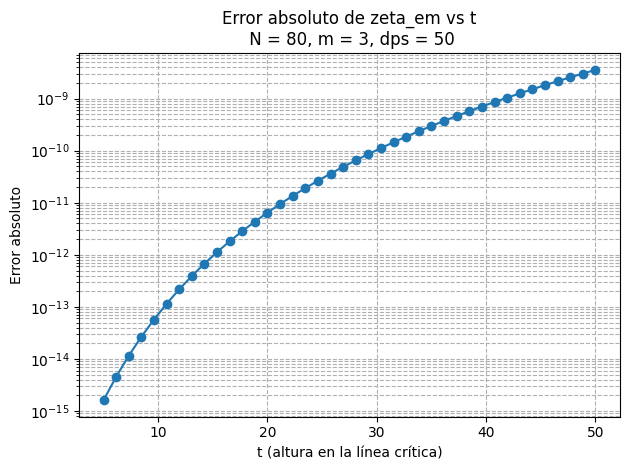

In [ ]:
def zeta_reference(t, dps_ref=100):

    # Trabajamos con más precisión solo dentro de este bloque
    with mp.workdps(dps_ref):
        s = mp.mpf('0.5') + 1j * mp.mpf(t)
        return mp.zeta(s)


def plot_error_vs_N(t=14.13472514, N_min=10, N_max=200, step=10, m=3, dps=50, use_relative=False):

    set_precision(dps)

    N_values = list(range(N_min, N_max + 1, step))
    errors = []

    # Calculamos referencia solo una vez
    z_ref = zeta_reference(t)

    for N in N_values:
        z_apx = zeta_em(t, N, m)
        err_abs = abs(z_ref - z_apx)
        if use_relative and z_ref != 0:
            err = err_abs / abs(z_ref)
        else:
            err = err_abs
        errors.append(err)

    plt.figure()
    plt.semilogy(N_values, errors, marker='o')
    plt.xlabel("N (punto de corte de la suma)")
    if use_relative:
        plt.ylabel("Error relativo")
        title_err = "relativo"
    else:
        plt.ylabel("Error absoluto")
        title_err = "absoluto"
    plt.title(f"Error {title_err} de zeta_em vs N\n t = {t}, m = {m}, dps = {dps}")
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()




def plot_error_vs_t(t_min=5, t_max=50, num_points=50, N=80, m=3, dps=50, use_relative=False):

    set_precision(dps)

    # Puntos de t igualmente espaciados
    t_values = [t_min + (t_max - t_min) * k / (num_points - 1) for k in range(num_points)]
    errors = []

    for t in t_values:
        z_ref = zeta_reference(t)
        z_apx = zeta_em(t, N, m)
        err_abs = abs(z_ref - z_apx)
        if use_relative and z_ref != 0:
            err = err_abs / abs(z_ref)
        else:
            err = err_abs
        errors.append(err)

    plt.figure()
    plt.semilogy(t_values, errors, marker='o')
    plt.xlabel("t (altura en la línea crítica)")
    if use_relative:
        plt.ylabel("Error relativo")
        title_err = "relativo"
    else:
        plt.ylabel("Error absoluto")
        title_err = "absoluto"
    plt.title(f"Error {title_err} de zeta_em vs t\n N = {N}, m = {m}, dps = {dps}")
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Ejemplo 1: error absoluto vs N cerca del primer cero
    plot_error_vs_N(
        t=14.13472514,
        N_min=10,
        N_max=200,
        step=10,
        m=3,
        dps=50,
        use_relative=False
    )

    # Ejemplo 2: error absoluto vs t en [5, 50] con N y m fijos
    plot_error_vs_t(
        t_min=5,
        t_max=50,
        num_points=40,
        N=80,
        m=3,
        dps=50,
        use_relative=False
    )



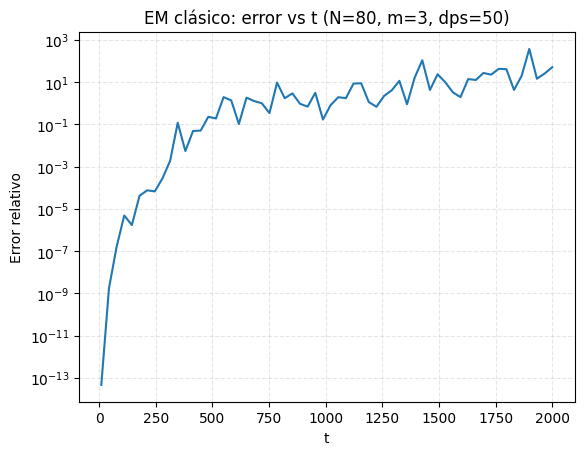

In [ ]:

# Gráfico: error vs t para EM clásico


def plot_error_vs_t_em(
    N=80,
    m=3,
    dps=50,
    t_min=10.0,
    t_max=2000.0,
    num_points=60,
    use_relative=True,
    dps_ref=100
):
    """
    Dibuja el error (absoluto o relativo) de la aproximación EM
    en función de t, para t en [t_min, t_max].

    N, m, dps: parámetros del método EM.
    dps_ref: precisión usada para el valor de referencia.
    """
    set_precision(dps)

    # Malla de t (puntos intermedios uniformemente espaciados)
    t_values = np.linspace(t_min, t_max, num_points)

    errors = []
    for t in t_values:
        z_ref = zeta_reference(t, dps_ref=dps_ref)
        z_apx = zeta_em(t, N, m)

        abs_err = mp.fabs(z_apx - z_ref)
        if use_relative and z_ref != 0:
            err = abs_err / mp.fabs(z_ref)
        else:
            err = abs_err
        errors.append(float(err))

    t_plot = [float(t) for t in t_values]

    plt.figure()
    plt.semilogy(t_plot, errors)
    plt.xlabel("t")
    plt.ylabel("Error relativo" if use_relative else "Error absoluto")
    plt.title(f"EM clásico: error vs t (N={N}, m={m}, dps={dps})")
    plt.grid(True, which="both", linestyle="--", alpha=0.3)
    plt.show()

plot_error_vs_t_em()